# Supporting code

Contact: ysong1@g.harvard.edu

The code in this notebook may be used to reproduce all results in the paper "Universal dynamics and microwave control of programmable resonant electro-optic frequency combs" by Y. Song, T. Lei, et. al., 2026. \
In particular, the results consider the cases of:
- high modulation depth [ edit "modulation_depth" parameter ]
- multi-tone driving with arbitrary modulation depth and relative phase [ edit "betas" and "phi_ms" parameters ]
- arbitrary optical detuning [ edit "theta_opt" parameter ]
- arbitrary microwave detuning [ edit "theta_mw" parameter ]
- arbitrary dispersion condition [ edit "beta2" parameter for quadratic dispersion ]
  
Please see the Supplementary information of the paper for detailed derivation of the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.special import jv
import time as time
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, sawtooth
import time as time
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.io import loadmat, savemat
# %matplotlib ipympl

# Preliminary parameters

In [2]:
# fundamental constants
c_const = 299792458

# size of the matrix
nmodes_per_side = 1000  # increase lattice size for higher Q devices
nmodes = 2*nmodes_per_side + 1
mu = np.arange(nmodes) - nmodes_per_side


# microresonator and driving conditions
q_i = 2e6
q_e = 2e6
fsr = 10e9
T_R = 1/fsr
freq_pump = 193e12 * 2*np.pi
freq_mw = fsr + 0.0e6
mw_detuning = freq_mw - fsr
opt_detuning = 0  # set optical detuning between -pi and pi (i.e., between -fsr/2 and fsr/2)


# dispersion
beta2 = 0.0e-24  # ps^2/m
ng = 2.30
D1 = 2*np.pi*fsr
D2 = -1 * (c_const/ng) * beta2 * D1**2

# General resonant EO comb formulation using extended coupled mode equations

Single modulation depth model and definitions (see Supplementary information for derivation from the Ikeda Map):
$$a_\mu^+e^{jD_{int}(\mu)t} = \bigg(\big(1-\frac{\theta}{2}\big)J_0(\beta_{MW,1})\bigg)a_\mu^-e^{jD_{int}(\mu)t}+j\sqrt{\theta_e}E_{in}e^{j\Delta_pt}\delta_{\mu,0}+\sum_{q=1}^\infty j^q\big(1-\frac{\theta}{2}\big)J_q(\beta_{MW,1})\bigg(a_{\mu+q}^-e^{-jq\Delta_{MW}t}e^{jD_{int}(\mu+q)t} + a_{\mu-q}^-e^{jq\Delta_{MW}t}e^{jD_{int}(\mu-q)t}\bigg)$$
$$a_\mu^+=a_\mu^-$$
$$|E_{in}|^2=P_{in}$$
$$\theta=\theta_e+\theta_i$$
$$\sqrt{1-\theta_e}\sqrt{1-\theta_i}\approx 1-\frac{\theta}{2}$$

Multi-tone model is a straightforward extension of the above case, also derived in the Supplementary information. \
Arbitrary-tone driving is achieved by setting the beta array $\{\beta_{MW,n}\}_n$ and phi_ms array $\{\phi_n\}_n$ ($n=10$ example shown in the following code), and the coupling coefficients and phases are found from numerical FFT of the total drive:
$$\mathcal{F}\bigg[exp(j\sum_n\beta_{MW,n}\cos(n\omega_{MW}t+\phi_n))\bigg]$$

Specifically, we provide driving conditions for three examples in the following. \
The user may change the dispersion, optical, and microwave detuning parameters to explore their effects on comb generation under such driving conditions.
1. Single-tone driving at the fundamental FSR [ high modulation depth and arbitrary detuning behavior ]
2. Multi-tone driving with square waves [ comb bandwidth extension ]
3. Multi-tone driving with ramp waves [ asymmetric comb generation ]

In [3]:
# Generate a sample signal
f_c = 1000  # Frequency of the sine wave (Hz)
fs = f_c * 20  # Sampling frequency (Hz)
t = np.arange(0, 40, 1/fs)  # Time vector (1 second duration)

f_center = f_c # THz
f_span = 300 # Hz
f_lo = f_center - f_span
f_hi = f_center + f_span

# modulation depth multiplier
n_spectrogram = 201
mdepths = np.linspace(0., 5.5, num=n_spectrogram)

total_time = 0
xs = []
xs_out = []

for kk, mdepth in enumerate(mdepths):
    print(f"{kk}, total time elapsed: {round(total_time/60, 2)} minutes...")
    iter_start_time = time.time()

    # multi-tone modulation depths
    # note: create an arbitrary modulation signal by loading the Fourier coefficients of it
    # three examples below
    # 1. fundamental FSR driving
    betas = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * np.pi * mdepth
    phi_ms = np.zeros((10,))
    # 2. square wave driving
    # betas = np.array([1, 0, 1/3, 0, 1/5, 0, 1/7, 0, 1/9, 0]) * np.pi * mdepth
    # phi_ms = np.ones((10,))*np.pi/2
    # 3. ramp driving
    # betas = np.array([1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9, 1/10]) * np.pi * mdepth
    # phi_ms = -1 ** np.arange(1, len(betas)+.1, 1)*np.pi/2
    
    f_ms = 2*np.arange(1, 11, 1)
    
    signal_pm_part = np.zeros((t.size,))
    for i in range(betas.size):
        signal_pm_part += betas[i]*np.cos(2*np.pi*f_ms[i]*t + phi_ms[i])  # cosines

    signal = np.cos(2*np.pi*f_c*t + signal_pm_part)

    # Compute the FFT
    fft_result = np.fft.fft(signal)
    n = len(signal)
    fft_amplitude = np.abs(fft_result)/n*2 # factor of 2 comes from the "mock" signal that is cosine, not exponential
    fft_phase = np.angle(fft_result)

    # Calculate the frequency axis
    fft_freqs = np.fft.fftfreq(n, 1/fs)

    # subset the data
    idx_subset = (fft_freqs > f_lo) & (fft_freqs < f_hi)
    freqs_subset = fft_freqs[idx_subset]
    fft_result_subset = fft_result[idx_subset]/n*2
    fft_amplitude_subset = np.abs(fft_result_subset)
    fft_phase_subset = np.angle(fft_result_subset)

    pk_idxs, _ = find_peaks(10*np.log10(fft_amplitude_subset), height=-70)

    npeaks = pk_idxs.size
    mus_subset_orders = (freqs_subset[pk_idxs] - f_c) // (f_ms[0])

    # dictionary for lookup table of complex coupling coefficients
    cc_complex_dict = {}
    for key, val in zip(mus_subset_orders, fft_result_subset[pk_idxs]):
        cc_complex_dict[int(key)] = val

    cc_real_dict = {}

    # coupling matrix initialization
    A = np.zeros((nmodes, nmodes), dtype=np.complex64)
    
    coupling_loss = freq_pump / q_e / fsr  # coupling loss per round trip [power loss]
    prop_loss = freq_pump / q_i / fsr  # propagation loss per round trip [power loss]
    total_trans = np.sqrt((1-coupling_loss)*(1-prop_loss))  # total field transmission per round trip

    Pin = 1
    Ein = np.sqrt(Pin) * np.exp(1j*0)

    # universal optical microwave detunings
    theta_opt = 0 # optical detuning
    for i in range(nmodes):
        for order in cc_complex_dict.keys():
            order = int(order)
            if (i-order >= 0) and (i-order < nmodes):
                theta_mw = mw_detuning / fsr * 2*np.pi * (i-nmodes_per_side-1-order) # microwave detuning
                theta_disp = (i-nmodes_per_side-1-order)**2 * D2/2 / fsr # dispersion detuning [dispersion => phase shift]
                theta_tot = theta_mw + theta_opt + theta_disp # total detuning
                A[i][i-order] = total_trans * cc_complex_dict[order] * np.exp(1j * theta_tot)
        
    A = np.identity(nmodes) - A
        
    b = np.zeros((nmodes, 1), dtype=np.complex64)
    theta_pump = theta_opt
    for i in range(nmodes):
        if i == nmodes_per_side+1:
            b[i][0] = 1j * np.sqrt(coupling_loss) * Ein * np.exp(1j * theta_pump)

    x = np.linalg.inv(A) @ b
    Ein_vec = np.zeros((nmodes,1), dtype=np.complex64)
    Ein_vec[nmodes_per_side+1][0] = Ein
    x_out = x*(1j)*np.sqrt(coupling_loss) + Ein_vec*np.sqrt(1-coupling_loss)
    

    xs.append(x) # intracavity
    xs_out.append(x_out) # out coupling
    
    iter_stop_time = time.time()
    iter_time = iter_stop_time - iter_start_time
    total_time += iter_time

0, total time elapsed: 0.0 minutes...
1, total time elapsed: 0.02 minutes...
2, total time elapsed: 0.04 minutes...
3, total time elapsed: 0.06 minutes...
4, total time elapsed: 0.08 minutes...
5, total time elapsed: 0.1 minutes...
6, total time elapsed: 0.12 minutes...
7, total time elapsed: 0.14 minutes...
8, total time elapsed: 0.16 minutes...
9, total time elapsed: 0.19 minutes...
10, total time elapsed: 0.21 minutes...
11, total time elapsed: 0.23 minutes...
12, total time elapsed: 0.25 minutes...
13, total time elapsed: 0.27 minutes...
14, total time elapsed: 0.3 minutes...
15, total time elapsed: 0.32 minutes...
16, total time elapsed: 0.34 minutes...
17, total time elapsed: 0.36 minutes...
18, total time elapsed: 0.39 minutes...
19, total time elapsed: 0.41 minutes...
20, total time elapsed: 0.44 minutes...
21, total time elapsed: 0.49 minutes...
22, total time elapsed: 0.54 minutes...
23, total time elapsed: 0.59 minutes...
24, total time elapsed: 0.62 minutes...
25, total tim

# Plot single

In [4]:
select_ii = 50 # index for which modulation depth to pick.
print(f"Selected modulation depth {mdepths[select_ii]} pi")

Selected modulation depth 1.375 pi


## Single spectrum

Plotting intracavity spectrum
Assumed FSR: 10.0 GHz


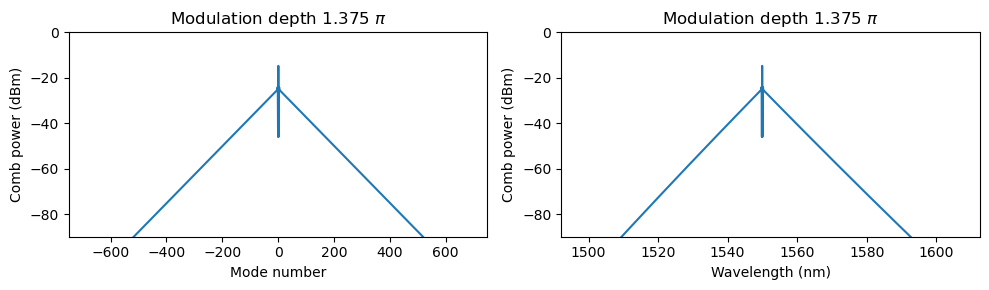

Plotting out coupled spectrum
Assumed FSR: 10.0 GHz


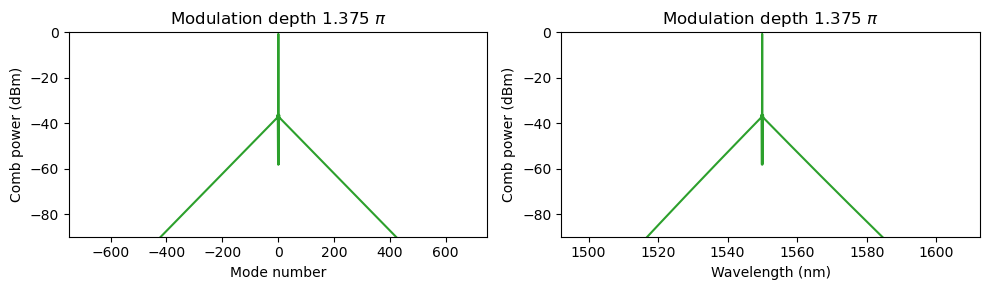

In [5]:
xlo = -750
xhi = -xlo

comb = 10*np.log10((np.abs(xs[select_ii])**2)) # intracavity
comb = np.nan_to_num(comb, neginf=-500)
comb_out = 10*np.log10((np.abs(xs_out[select_ii])**2)) # out coupling
comb_out = np.nan_to_num(comb_out, neginf=-500)

# plot intracavity
print("Plotting intracavity spectrum")
fig, axs = plt.subplots(figsize=(10, 3), ncols=2)
axs[0].plot(mu, comb)
axs[0].set_ylim(-90, 0)
axs[0].set_xlim(xlo, xhi)
axs[0].set_title(rf"Modulation depth {mdepths[select_ii]} $\pi$")
axs[0].set_xlabel("Mode number")
axs[0].set_ylabel("Comb power (dBm)")

lda0 = 1550e-9
f0 = c_const/lda0
fs = mu*fsr + f0
print(f"Assumed FSR: {fsr/1e9} GHz")
axs[1].plot(c_const/fs*1e9, comb)
axs[1].set_ylim(-90, 0)
axs[1].set_xlim(c_const/(xhi*fsr+f0)*1e9, c_const/(xlo*fsr+f0)*1e9)
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Comb power (dBm)")
axs[1].set_title(rf"Modulation depth {mdepths[select_ii]} $\pi$")

plt.tight_layout()
plt.show()


# plot out coupling
print("Plotting out coupled spectrum")
fig, axs = plt.subplots(figsize=(10, 3), ncols=2)
axs[0].plot(mu, comb_out, color='tab:Green')
axs[0].set_ylim(-90, 0)
axs[0].set_xlim(xlo, xhi)
axs[0].set_title(rf"Modulation depth {mdepths[select_ii]} $\pi$")
axs[0].set_xlabel("Mode number")
axs[0].set_ylabel("Comb power (dBm)")

lda0 = 1550e-9
f0 = c_const/lda0
fs = mu*fsr + f0
print(f"Assumed FSR: {fsr/1e9} GHz")
axs[1].plot(c_const/fs*1e9, comb_out, color='tab:Green')
axs[1].set_ylim(-90, 0)
axs[1].set_xlim(c_const/(xhi*fsr+f0)*1e9, c_const/(xlo*fsr+f0)*1e9)
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Comb power (dBm)")
axs[1].set_title(rf"Modulation depth {mdepths[select_ii]} $\pi$")

plt.tight_layout()
plt.show()

## Single time profile

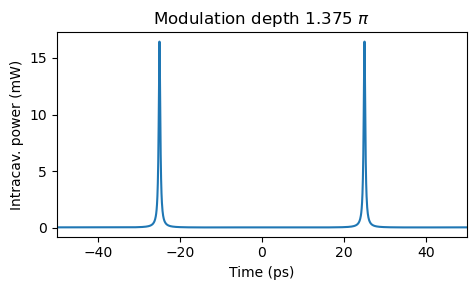

In [6]:
# intracavity
time_intracav = np.abs(np.fft.ifft(np.fft.ifftshift(xs, axes=1)*(nmodes_per_side*2+1), axis=1))**2
time_axis = np.linspace(-0.5/fsr*1e12, 0.5/fsr*1e12, num=nmodes_per_side*2+1)

fig, axs = plt.subplots(figsize=(5, 3))
axs.plot(time_axis, time_intracav[select_ii])
axs.set_xlim(-0.5/fsr*1e12, 0.5/fsr*1e12)
axs.set_title(rf"Modulation depth {mdepths[select_ii]} $\pi$")
axs.set_xlabel("Time (ps)")
axs.set_ylabel("Intracav. power (mW)")

plt.tight_layout()
plt.show()

# Plot spectrogram

C:\Users\tonys\AppData\Local\Temp\ipykernel_39812\362148135.py:1: RuntimeWarning: divide by zero encountered in log10
  comb_intracav = 10*np.log10(np.abs(xs)**2)


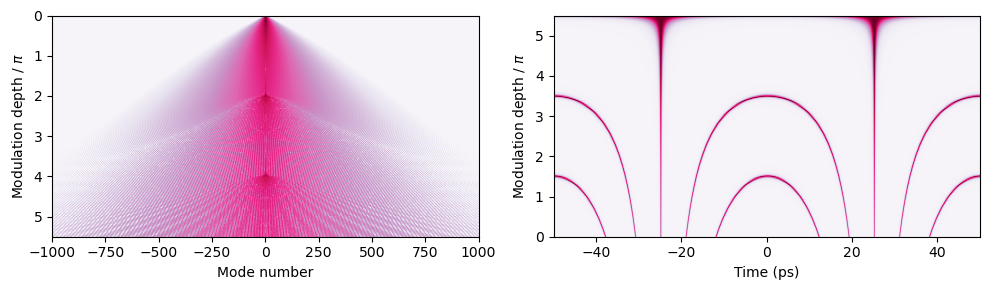

In [7]:
comb_intracav = 10*np.log10(np.abs(xs)**2)
comb_intracav = np.nan_to_num(comb_intracav, neginf=-500)
time_intracav = np.abs(np.fft.ifft(np.fft.ifftshift(xs, axes=1)*(nmodes_per_side*2+1), axis=1))**2

fig, axs = plt.subplots(figsize=(10, 3), ncols=2)
freq_extent = [-nmodes_per_side, nmodes_per_side, mdepths[-1], mdepths[0]]
axs[0].imshow(comb_intracav, extent=freq_extent, vmin=-80, vmax=0, aspect='auto', cmap='PuRd')
axs[0].set_xlabel("Mode number")
axs[0].set_ylabel("Modulation depth / $\pi$")

time_extent = [-0.5/fsr*1e12, 0.5/fsr*1e12, mdepths[0], mdepths[-1]]
# axs[1].imshow(time_intracav, extent=time_extent, cmap='PuRd', aspect='auto')
axs[1].imshow(time_intracav, extent=time_extent, cmap='PuRd', aspect='auto')
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel("Modulation depth / $\pi$")
plt.tight_layout()
plt.show()